# Build a Multi-output Model

This notebook demonstrates how to create a model with more than one output. 

The dataset is from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). The data explores the features of 12 different building shapes. The heating load and cooling load columns will be used for output. 

The code below is adapted from a Coursera Course on TF.

In [9]:
# imports

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
# extract the two output columns
#   and covert to NumPy arrays
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


# normalize using mean and standard deviation
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


# plot the difference between y and y-hat
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


# plot validation metric
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Data

Download the dataset and format it for training.

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'
df = pd.read_excel(url)

df.head

<bound method NDFrame.head of        X1     X2     X3      X4   X5  X6   X7  X8     Y1     Y2
0    0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55  21.33
1    0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55  21.33
2    0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55  21.33
3    0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55  21.33
4    0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84  28.28
..    ...    ...    ...     ...  ...  ..  ...  ..    ...    ...
763  0.64  784.0  343.0  220.50  3.5   5  0.4   5  17.88  21.40
764  0.62  808.5  367.5  220.50  3.5   2  0.4   5  16.54  16.88
765  0.62  808.5  367.5  220.50  3.5   3  0.4   5  16.44  17.11
766  0.62  808.5  367.5  220.50  3.5   4  0.4   5  16.48  16.61
767  0.62  808.5  367.5  220.50  3.5   5  0.4   5  16.64  16.03

[768 rows x 10 columns]>

In [4]:
# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2, random_state=1234)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [5]:
# Define model layers.
input_layer = Input(shape=(len(train.columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          1152        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 64)           8256        ['dense_1[0][0]']                
                                                                                              

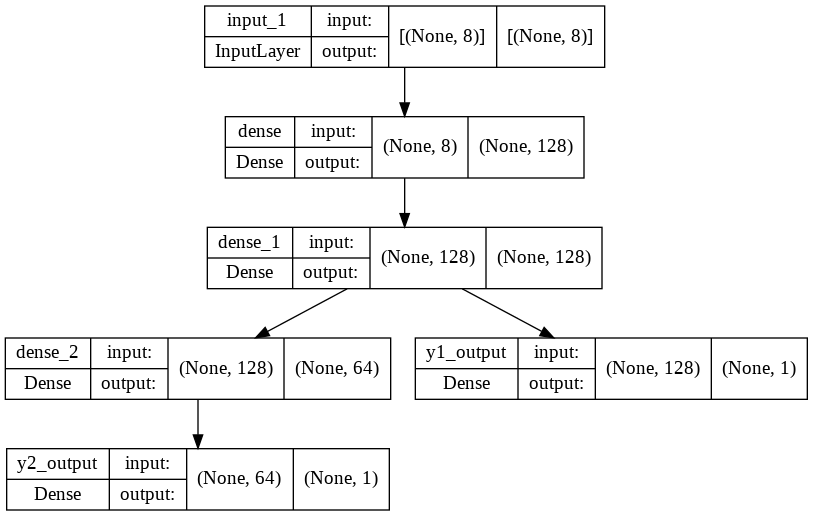

In [10]:
keras.utils.plot_model(model, "Multiple_Output_Model.png", show_shapes=True)

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [11]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


## Train the Model

In [12]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 1s 8ms/step - loss: 278.5839 - y1_output_loss: 132.6882 - y2_output_loss: 145.8957 - y1_output_root_mean_squared_error: 11.5190 - y2_output_root_mean_squared_error: 12.0787 - val_loss: 51.9641 - val_y1_output_loss: 16.7010 - val_y2_output_loss: 35.2631 - val_y1_output_root_mean_squared_error: 4.0867 - val_y2_output_root_mean_squared_error: 5.9383
Epoch 2/500
62/62 [==============================] - 0s 3ms/step - loss: 37.0196 - y1_output_loss: 13.7151 - y2_output_loss: 23.3044 - y1_output_root_mean_squared_error: 3.7034 - y2_output_root_mean_squared_error: 4.8275 - val_loss: 55.5097 - val_y1_output_loss: 13.3663 - val_y2_output_loss: 42.1433 - val_y1_output_root_mean_squared_error: 3.6560 - val_y2_output_root_mean_squared_error: 6.4918
Epoch 3/500
62/62 [==============================] - 0s 4ms/step - loss: 31.0187 - y1_output_loss: 11.3037 - y2_output_loss: 19.7151 - y1_output_root_mean_squared_error: 3.3621 - y2_output_root_mean_sq

## Evaluate the Model and Plot Metrics

In [13]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 4ms/step - loss: 0.7000 - y1_output_loss: 0.2217 - y2_output_loss: 0.4783 - y1_output_root_mean_squared_error: 0.4709 - y2_output_root_mean_squared_error: 0.6916
Loss = 0.7000464200973511, Y1_loss = 0.2217402458190918, Y1_mse = 0.4708930253982544, Y2_loss = 0.4783061742782593, Y2_mse = 0.6915968060493469


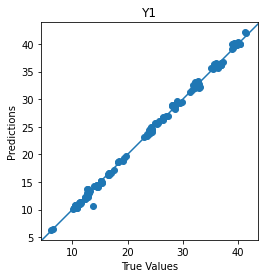

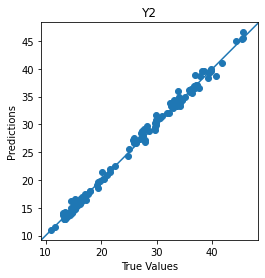

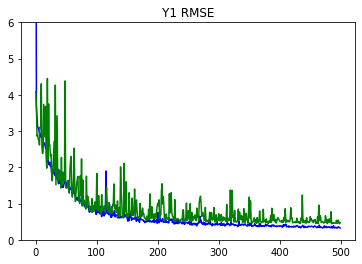

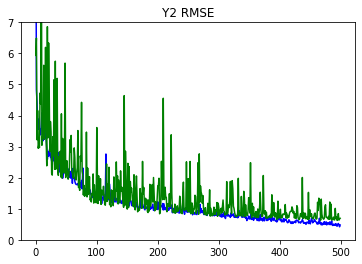

In [14]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)